(sec:MCMC)=
# Markov chain Monte Carlo sampling

```{epigraph}
> "I decry the current tendency to seek patents on algorithms. There are better ways to earn a living than to prevent other people from making use of one's contributions to computer science."

-- Donald Knuth
```


In this chapter we will return to Bayesian inference and show how custom design of Markov chains provides an enabling technology to address also high-dimensional problems. The posterior PDF $\pdf{\pars}{\data, I}$ is a key quantity in the Bayesian approach. The approach that will be outlined here is general to any PDF $p(\pars)$ so we will just use this simple notation.

## General problems in Bayesian inference

We might be interested in:

1. The exploration of the PDF; 
   - Where is the probability mass concentrated?
   - Are there correlations between parameters?
   - Are there multiple modes?
   - How do the marginal PDFs look like?
2. The exploration of posterior predictions with a function $g(\pars)$;
   - Finding the **posterior predictive distribution** 
     \begin{equation}
     \{ g(\pars) \; : \; \pars \sim p(\pars) \}
     \end{equation}
	- The evaluation of **expectation values**
	
	  $$
        \expect{g(\pars)} = \int d\pars g(\pars) p(\pars)
      $$ (eq:MCMC:expectation-integral)

The first set of tasks can be addressed with a method to collect a set of samples $\{ \pars_i\}_{i=1}^N$, where the samples are distributed according to $p(\pars)$. The process of generating a random sample according to a probability distribution is commonly called a "draw"". Such samples can then be histogramed and plotted to provide an approximate representation of $p(\pars)$.

In particular, it should be noted that marginal distributions can easily be obtained from these samples by ignoring the values of parameters that we are integrating over. For example, the marginal distribution $p(\para_1,\para_2)$ of $p(\pars)$ with $\pars$ a $D$-dimensional vector is represented by the samples 

$$
\{ (\para_1,\para_2)_i \}_{i=1}^N,
$$

where $(\para_1,\para_2)_i$ are the first two elements of the $\pars_i$ sample. This procedure of ignoring the other parameter values can be understood since the process of marginalization is basically a projection of the multi-dimensional PDF onto the chosen axes. 

The computation of high-dimensional integrals such as in Eq. {eq}`eq:MCMC:expectation-integral` is very challenging in high dimensions. In fact, high-dimensional integrals appear frequently in science and applied mathematics. It is only anaytically solvable in some special cases and is therefore an important and general problem. It turns out that the ability to draw samples from $p(\pars)$ will make it possible to compute very efficient, numerical approximations of this integral also in very high dimensions.

## Numerical integration

There are several methods to perform numerical integration. Quadrature is the method of choice for small numbers of dimensions, while Monte Carlo integration becomes very powerful in high dimensions.

### Quadrature methods

For small dimensions, classical numerical integration using quadrature is often the method of choice. For example, the one-dimensional integral

\begin{equation}
I = \int d\para f(\para),
\end{equation}

is approximated by a weighted average of the function $f$ evaluated at a number of quadrature points $\{ \para_i \}_{i=1}^N$

\begin{equation}
I \approx \sum_{i=1}^N w_i f(\para_i),
\end{equation}

where the different quadrature schemes are distinguished by using different sets of design points and weights. We note, however, that the number of design points that is required for a fixed precision grows exponentially with dimension. Assuming an integration scheme with $N$ design points in one dimension, the same coverage in $D$ dimensions requires $N^D$ design points, which will be impractically large unless $D$ is sufficiently small. This exponential increase in the number of required function evaluations with the dimensionality of the problem is often called the curse of dimensionality and is the main motivation for Monte Carlo integration.

### Monte Carlo integration

The most straightforward implementation of Monte Carlo integration provides an estimate of the $D$-dimensional integral

$$
I = \int_{V_D} d\pars f(\pars) \approx I_N \equiv \frac{V_D}{N} \sum_{i=1}^N f(\pars_i),
$$ (eq:MCMC:MC-integration)

where $\{ \pars_i \}_{i=1}^N$ are $N$ uniformly distributed points in the $D$ dimensional volume $V_D$ of the parameter space. The convergence of this expression will not be proven here, but is a consequence of the law of large numbers. Furthermore, one can show that the error in this approximation (usually) decreases as $1/\sqrt{N}$ regardless of the dimensionality $D$, which is the main reason for its usefulness when facing complicated, high-dimensional integrals. To be specific, the variance of $I_N$ can be estimated by the sample variance 

\begin{equation}
\sigma_N^2 = \frac{1}{N-1} \sum_{i=1}^N \left( f(\pars_i) - \langle f \rangle \right)^2,
\end{equation}

where $\langle f \rangle$ is the sample mean, and becomes

\begin{equation}
\text{Var}(I_N)) = V_D^2 \frac{\sigma_N^2}{N}.
\end{equation}

```{prf:example} Monte Carlo estimation of $\pi$
A standard example of Monte Carlo integration is the estimation of $\pi$ using the (circular) step function

\begin{equation}
f(x,y) = \left\{ 
\begin{array}{ll}
1 & \text{if $x^2+y^2 \leq 1$} \\
0 & \text{otherwise},
\end{array}
\right.
\end{equation}

such that the integral

\begin{equation}
I = \int_{-1}^1 dx \int_{-1}^1 dy f(x,y) = \pi.
\end{equation}


One can estimate $I$ using $N$ samples $\{ (x_i,y_i) \}_{i=1}^N $ from the bivariate, uniform distribution $\mathcal{U} \left( [-1,1]^2 \right)$ such that

$$
I \approx I_N = \frac{4}{N} \sum_{i=1}^N f(x_i,y_i),
$$ (eq:MCMC:MC-integration-pi)

according to Eq. {eq}`eq:MCMC:MC-integration`. In the code cell below we implement this Monte Carlo integration using python and show that the (relative) error of this numerical simulation of $\pi$ indeed decreases as $1/\sqrt{N}$.
```

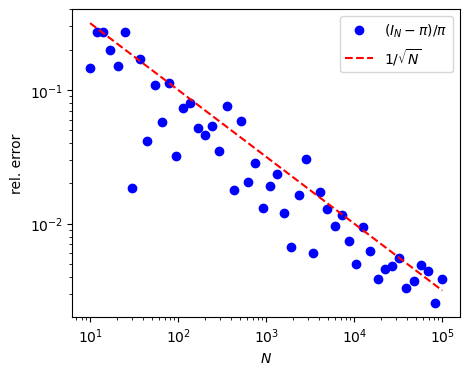

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

num_samples=[int(10**i) for i in np.linspace(1,5,50)]
I_num = []
I_rel_error = []
for num in num_samples:
    max_I_num = 0.
    # We will do ten simulations and find the largest error that is made
    for iexp in range(10):
        # `num` bivariate samples from a uniform distribution [-1,1]**2
        samples = stats.uniform.rvs(loc=-1,scale=2,size=(2,num))
        # Boolean array with elements that are true if the sample is inside the unit circle
        # This corresponds to the unit circle step function
        inside = samples[0,:]**2 + samples[1,:]**2 <= 1
        # We can evaluate the Monte Carlo sum
        iexp_I_num = 4.0 * np.sum(inside) / num
        # We keep the largest error that we find in all experiments
        max_I_num = max(max_I_num,iexp_I_num)
        
    I_num.append(max_I_num)
    # And the (absolute value) of the relative error
    I_rel_error.append(np.abs(I_num[-1]-np.pi)/np.pi)
    
num_samples = np.array(num_samples)
I_rel_error = np.array(I_rel_error)

fig, ax = plt.subplots(nrows=1, ncols=1, **{"figsize":(5,4)})
ax.loglog(num_samples, I_rel_error, 'bo',label=r'$(I_N-\pi) / \pi$')
ax.loglog(num_samples, 1/np.sqrt(num_samples),'r--',label=r'$1/\sqrt{N}$')
ax.set_xlabel(r'$N$')
ax.set_ylabel('rel. error')
ax.legend(loc='best');

from myst_nb import glue
glue("MC-integration_fig", fig, display=False)

```{glue:figure} MC-integration_fig
:name: "fig-MC-integration"

Relative error of the Monte Carlo integration {eq}`eq:MCMC:MC-integration-pi` as a function of the number of samples, demonstrating the $1/\sqrt{N}$ scaling.
```

Despite the favorable $1/\sqrt{N}$-scaling, the problem of straight-forward Monte Carlo integration is that you will often evaluate the integrand at locations where it is small. This affects the precision of the approximation due to the volume factor and since the sample variance is large. It would be more beneficial to focus the sampling to regions that contribute significantly to the integral. 

### Monte Carlo integration in statistics

Indeed, it turns out that significantly better precision can be achieved for integrals such as {eq}`eq:MCMC:expectation-integral`, that appear in statistical computations. Given that we have a method to collect samples $\{ \pars_i \}_{i=1}^N$ from $p(\pars)$, we find that

$$
I = \int_{V_D} d\pars g(\pars) p(\pars) \approx I_N \equiv \frac{1}{N} \sum_{i=1}^N g(\pars_i),
$$ (eq:MCMC:MC-pdf-integration)

where you should note that the volume factor has disappeared and that you only evaluate $g(\pars)$ at the sampled positions where the PDF is usually large.

## Sampling from a PDF

We have seen that the ability to draw samples from a probability distribution is very useful. If $p(\pars)$ is of a standard form then it is straightforward to sample from it using available algorithms, most of which are based on nonlinear transformations of uniformly distributed random numbers. For example, a set of samples $\{ u_i\}_{i=1}^N$ from the one-dimensional standard uniform distribution $\mathcal{U}([0,1])$ 
can be tuned to a a set of samples $\{ \para_i \}_{i=1}^N$ from the standard Gaussian distribution $\mathcal{N}(0,1)$ via the transformation

\begin{equation}
\para_i = F^{-1}_{\mathcal{N}}(u_i),
\end{equation}

where $F^{-1}_{\mathcal{N}}$ is the *inverse* distribution function of the standard normal distribution. That is, we interpret $u_i$ as a probability sample and use the above transformation to find the solution to $u_i = F(\para_i)$.

This works well for many standard distributions. However, for the generation of random samples from nonstandard, arbitrary distributions (such as the ones that we might encounter in a realistic Bayesian analysis), no algorithms are available. This is where custom-built Markov chains enter.

## The Metropolis-Hastings algorithm

How can we collect random samples from an arbitrary probability distribution $p(\pars)$? In particular, how can we perform this task when we might not even have a closed form expression for the PDF? It is common in Bayesian inference that we find ourselves in the situation that we can evaluate $p(\pars)$ at any position $\pars$, but we don't know beforehand if it will be large or small.

We will now show that it is possible to construct a Markov chain that has $p(\pars)$ as its stationary distribution. Once this chain has converged it will provide us with samples from $p(\pars)$. 

As we have learned, the evolution of positions is described by the transition density $T$. The generalization to continuous variables of the stationary-chain equilibrium described in Eq. {eq}`eq:MarkovChains:discrete-equlibrium` is

\begin{equation}
p(\pars) = \int_{\Omega'} p(\pars')T(\pars',\pars) d\pars'.
\end{equation}

This equilibrium condition can be replaced with the more stringent **detailed-balance** condition

$$
p(\pars)T(\pars,\pars') = p(\pars') T(\pars',\pars),
$$ (eq:MCMC:detailed-balance)

which can be understood from the integral relation

\begin{equation}
\int d\pars' p(\pars)T(\pars,\pars') = \int d\pars' p(\pars') T(\pars',\pars),
\end{equation}

that describes the balance between the transitions of probability density out of $\pars$ and into $\pars$. At equilibrium, these integrals must be equal.


The trick to achieve this for a certain $p(\pars)$ is to write $T$ as a product of a simple step proposal function $S(\pars,\pars')$, that provides probability densities for steps in $\pars$-space, and a function $A(\pars,\pars')$ that we will call the **acceptance probability**

\begin{equation}
T(\pars,\pars') = A(\pars,\pars') S(\pars,\pars').
\end{equation}

The step proposal function can be almost anything, but a key property is that it should be easy to draw a sample from it. The probability for proposing a new position $\pars'$ will depend on the current position $\pars$

\begin{equation}
\pdf{\text{proposing $\pars'$}}{\text{current position}=\pars} = S(\pars,\pars')
\end{equation}

For example, assuming that $\pars$ is a vector in a $D$-dimensional parameter space we can take $S(\pars,\pars')$ to be a uniform distribution within a $D$-dimensional hypercube with side length $\Delta$

\begin{equation}
S(\pars,\pars') = \left\{ 
\begin{array}{ll}
\frac{1}{\Delta^D} & \text{if $\left| \pars'_i - \pars_i \right| \leq \frac{\Delta}{2}$ for all $i \in \{1, \ldots, D\}$} \\
0 & \text{otherwise}
\end{array}
\right.
\end{equation}

Alternatively we can use a multivariate Gaussian distribution with a mean that corresponds to the current position $\pars$ and a covariance matrix that we can specify. 

The probability of actually accepting the proposed step from $\pars$ to $\pars'$ will then be given by $0 \leq A(\pars,\pars') \leq 1$.

The detailed balance condition {eq}`eq:MCMC:detailed-balance` can be fulfilled by placing the following condition on the acceptance probability

\begin{equation}
\frac{A(\pars,\pars')}{A(\pars',\pars)} = \frac{p(\pars')S(\pars',\pars)}{p(\pars)S(\pars,\pars')}.
\end{equation}

The expression for $A$ that fulfils this condition is

\begin{equation}
A(\pars,\pars') = \text{min} \left( \frac{p(\pars')S(\pars',\pars)}{p(\pars)S(\pars,\pars')},1\right),
\end{equation}

and holds the probability by which we decide whether to accept the proposed position $\pars'$, or remain in the old one $\pars$. The ratio that appears in the acceptance probability is called the Metropolis-Hastings ratio and will here be denoted $r$. We note that it gets further simplified for symmetric proposal functions (for which it is sometimes referred to as the Metropolis ratio)

$$
r = \left\{
\begin{array}{ll}
\frac{p(\pars')S(\pars',\pars)}{p(\pars)S(\pars,\pars')} 
& \text{for general proposal functions}, \\
\frac{p(\pars')}{p(\pars)}
& \text{for symmetric proposal functions}.
\end{array}
\right.
$$ (eq:MCMC:metropolis-ratio)

Note how the proposal function $S(\pars,\pars')$ in combination with the acceptance probability $A(\pars,\pars') = \text{min} (r,1)$ provides a simple process for generating samples in a Markov chain that has the required equilibrium distribution. It only requires simple draws of proposal steps, and the evaluation of $p$ at these positions. It is stochastic due to the random proposal of steps and since the decision to accept a proposed step contains randomness via the acceptance probability.

```{note}
The proposal function must allow the chain to be irreducible, positively recurrent and aperiodic.
```


The basic structure of the Metropolis (and Metropolis-Hastings) algorithm is the following:

```{prf:algorithm} The Metropolis-Hastings algorithm
1. Initialize the sampling by choosing a starting point $\boldsymbol{\pars}_0$.
2. Collect samples by repeating the following:
   1. Given $\boldsymbol{\pars}_i$, *propose* a new point $\boldsymbol{\phi}$, sampled from the proposal distribution $S( \boldsymbol{\pars}_i, \boldsymbol{\phi} )$. This proposal distribution could take many forms. However, for concreteness you can imagine it as a multivariate normal with mean vector given by $\boldsymbol{\pars}_i$ and (position-independent) variances $\boldsymbol{\sigma}^2$ specified by the user.
      * The propsal function will (usually) give a smaller probability for visiting positions that are far from the current position.
      * The width $\boldsymbol{\sigma}$ determines the average step size and is known as the proposal width.
   2. Compute the Metropolis(-Hastings) ratio $r$ given by Eq. {eq}`eq:MCMC:metropolis-ratio`. For symmetric proposal distributions, with the simpler expression for the acceptance probability, this algorithm is known as the Metropolis algorithm.
   3. Decide whether or not to accept candidate $\boldsymbol{\phi}$ for $\boldsymbol{\pars}_{i+1}$. 
      * If $r \geq 1$: accept the proposal position and set $\boldsymbol{\pars}_{i+1} = \boldsymbol{\phi}$.
      * If $r < 1$: accept the position with probability $r$ by sampling a uniform $\mathcal{U}([0,1])$ distribution (note that now we have $0 \leq r < 1$). 
        - If $u \sim \mathcal{U}([0,1]) \leq r$, then $\boldsymbol{\pars}_{i+1} = \boldsymbol{\phi}$ (accept); 
        - else $\boldsymbol{\pars}_{i+1} = \boldsymbol{\pars}_i$ (reject). 
        
      Note that the chain always grows since you add the current position again if the proposed step is rejected.
   4. Iterate until the chain has reached a predetermined length or passes some convergence tests.
   ```

* The Metropolis algorithm dates back to the 1950s in physics, but didn't become widespread in statistics until almost 1980.
* It enabled Bayesian methods to become feasible.
* Note, however, that nowadays there are much more sophisticated samplers than the original Metropolis one.

## State-of-the-art MCMC implementations

Here is an (incomplete) list of state-of-the-art MCMC implementations and packages that are available in Python (and often other languages)

```{admonition} emcee:
  [emcee](https://emcee.readthedocs.io/en/latest/) {cite}`Foreman_Mackey_2013` is an MIT licensed pure-Python implementation of Goodman & Weare’s [Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler](http://msp.berkeley.edu/camcos/2010/5-1/p04.xhtml) {cite}`Goodman2010`
  ```
  
```{admonition} PyMC3:
  [PyMC3](https://docs.pymc.io/) is a Python package for Bayesian statistical modeling and probabilistic machine learning which focuses on advanced Markov chain Monte Carlo and variational fitting algorithms.
  ```
  
```{admonition} PyStan:
  [PyStan](https://pystan.readthedocs.io/en/latest/) provides an interface to [Stan](http://mc-stan.org/), a package for Bayesian inference using the No-U-Turn sampler, a variant of Hamiltonian Monte Carlo.
  ```
  
```{admonition} PyMultiNest:
  [PyMultiNest](https://johannesbuchner.github.io/PyMultiNest/) interacts with [MultiNest](https://github.com/farhanferoz/MultiNest) {cite}`Feroz2009`, a Nested Sampling Monte Carlo library.
  ```

## Visualizations of MCMC
* There are excellent javascript visualizations of MCMC sampling on the internet.
* A particularly useful set of interactive demos was created by Chi Feng, and is available on the github page: [The Markov-chain Monte Carlo Interactive Gallery](https://chi-feng.github.io/mcmc-demo/)
* An accessible introduction to MCMC, with simplified versions of Feng's visualizations, was created by Richard McElreath. It promotes Hamiltonian Monte Carlo and is available in a blog entry called [Markov Chains: Why Walk When You Can Flow?](http://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/) 

Assume that we have $N$ samples from the joint pdf. This might be the Markov Chain from an MCMC sampler: $\left\{ (\theta_0, \theta_1)_i \right\}_{i=0}^{N-1}$. Then the marginal distribution of $\theta_1$ will be given by the same chain by simply ignoring the $\theta_0$ column, i.e., $\left\{ \theta_{1,i} \right\}_{i=0}^{N-1}$. 

<!-- !split -->
## Challenges in MCMC sampling
There is much to be written about challenges in performing MCMC sampling and diagnostics that should be made to ascertain that your Markov chain has converged (although it is not really possible to be 100% certain except in special cases.)

We will not focus on these issues here, but just list a few problematic pdfs:
* Correlated distributions that are very narrow in certain directions. (scaled parameters needed)
* Donut or banana shapes. (very low acceptance ratios)
* Multimodal distributions. (might easily get stuck in local region of high probability and completely miss other regions.)

## Exercises

```{exercise} Metropolis sampling of a uniform distribution
:label: exercise:metropolis-sampling-uniform

Show that the update rule implemented in {prf:ref}`example:reversible-markov-process` has the uniform distribution $\mathcal{U}(0,1)$ as its limiting distribution.

```

```{exercise} Power-law distributions
:label: exercise:power-law-distribution-sampling

Discrete power-law distributions have the general form $p(i) \propto i^\alpha$. for some constant $\alpha$. Unlike exponentially decaying distributions (such as the normal distribution and many others), power-law distributions have *fat tails*. They are therefore often used to model skewed data sets. Let

$$
\pi_i = \frac{i^{-3/2}}{\sum_{k=1}^\infty k^{-3/2}}, \quad \text{for } i = 1, 2, \ldots
$$

Implement a Metropolis algorithm to sample for $\boldsymbol{\pi}$.

```

```{exercise} The Metropolis algorithm for a discrete distribution
:label: exercise:MCMC:discrete-metropolis

Use the Metropolis algorithm as outlined in {prf:ref}`remark:MCMC:Metropolis-discrete` to construct a transition matrix $T$ for a Markov chain that gives the discrete limiting distribution

$$
\pi = \left(\frac{1}{9},\frac{3}{4},\frac{5}{36}\right).
$$


Assume that the step proposal matrix has $S(i,j)=1/3$ for all $i,j$.

- Compute $T$ by hand, or numerically using Python. Verify that it is a valid transition matrix and that the above distribution is stationary.

- Verify that $\pi$ and $T$ fulfills detailed balance. 

- Note that this distribution is the limiting distribution found in {numref}`exercise:stationary-gothenburg-winter-weather`. However, the transition matrices are not the same. Try to explain why. Can you construct other transition matrices with the same limiting distribution?

- Construct the Markov chain outcomes of random variable $\{X_n\}$ numerically. Plot the convergence of the discrete distribution for different 
starting distributions and see if the correct limiting distribution is obtained.

```


## Solutions

```{solution} exercise:metropolis-sampling-uniform
:label: solution:metropolis-sampling-uniform
:class: dropdown

Check the acceptance criterion.

```

````{solution} exercise:power-law-distribution-sampling
:label: solution:power-law-distribution-sampling
:class: dropdown

It is suggested to use $\{-1,1\}$ as the proposal step (with $p=0.5$ a step to the left). The acceptence fraction involves a ratio of probabilities, which removes the infinite sum in the denominator. Note also that the acceptance criterion must include the reflective boundary at $i=1$.

````

````{solution} exercise:MCMC:discrete-metropolis
:label: solution:MCMC:discrete-metropolis
:class: dropdown

- Construct the $T$-matrix

$$
T =
\begin{pmatrix}
0.33333333 & 0.33333333 & 0.33333333 \\
0.04938272 & 0.88888889 & 0.0617284 \\
0.26666667 & 0.33333333 & 0.4       
\end{pmatrix}
$$

and note that all elements are positive and that the row sums equal one. You can verify by hand that $\pi = \pi T$ with the given distribution.

- Eq. {eq}`eq:MarkovChains:detailed-balance` gives nine equalities that should be checked.

- The stationary distribution $\pi$ is a left eigenvector of $T$ with eigenvalue $+1$. But there is no uniqueness theorem that dictates that there can only be one matrix with this eigenvalue/vector. It is easy to create other transition matrices with the same limiting distribution by just changing the step proposal matrix.

- Generate the Markov chain and see that it converges

```{code-block} python
import numpy as np

t=np.array([[0.33333333, 0.33333333, 0.33333333],
 [0.04938272, 0.88888889, 0.0617284 ],
 [0.26666667, 0.33333333, 0.4       ]])

N = 40 # Number of steps
x0 = np.array([1,0,0]) # Start distribution

X = []
X.append(x0)
for i in range(1,N):
    X.append(np.matmul(X[i-1],t))

X = np.array(X)
print(X)
```

 
````